In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from scipy.stats import norm
np.set_printoptions(threshold=np.inf)
from numpy.random import Generator, MT19937, SeedSequence
rs = Generator(MT19937(SeedSequence(42)))
from quadrotor_dynamics import system_parameters, euler_to_quaternion, QuadrotorDynamics
from gd_qdt import run_gd
import sys

In [5]:
def traj_gen(M,N,epsilon):
    rs = Generator(MT19937(SeedSequence(0)))
    # --------------------------ground_truth parameters-----------------------------
    I_xx, I_yy, I_zz, Ax, Ay, Az, m, _, _, _, _ = system_parameters()
    # ground_truth = [1 / m, -Ax / m, -Ay / m, -Az / m,
    #             (I_yy - I_zz) / I_xx, 1 / I_xx,
    #             (I_zz - I_xx) / I_yy, 1 / I_yy,
    #             (I_xx - I_yy) / I_zz, 1 / I_zz]

    # N = 20       # number trajectories
    max_time_hor = 10      # maximum trajectory length
    # ------------------------------disturbacne-------------------------------------
    # disturbance: str = "trunc_guass"
    # parameter_dist = [0.0, 0.5, 1]  # mean and std

    disturbance: str = "uniform"
    parameter_dist = [-1, 1]  # lb and ub

    seeds_w = range(300, 500) # fixing seeds
    w_max = 0.01             # maximum disturbance (required to run set membership)

    # ---------------------------------noise----------------------------------------
    # c_input: str = "trunc_guass"
    # parameter_input = [0.0, 0.1, 1]  # mean and std

    c_input: str = "uniform"
    parameter_input = [-1, 1]  # lb and ub

    mult_u = [1, 0.2, 0.2, 0.2]

    seeds_u = range(100, 200)   # fixing seeds

    # print('------------------Getting Trajectory Data of Quadrotor-----------------')

    theta_hat_list = []
    Delta_S_list = []
    Phi_S_U_list = []
    # m_mod=0.8
   
    m_mod=[1/m + epsilon * rs.random() for _ in range(M) ]
    Ax_mod=[Ax + epsilon * rs.random()  for _ in range(M) ]
    Ay_mod=[Ay + epsilon * rs.random()  for _ in range(M) ]
    Az_mod=[Az + epsilon * rs.random()  for _ in range(M) ]
    # m_mod=[]

    # print(m_mod)
    global_ground_truth=[]
    for j in range(M):
        # ground_truth = [1 / m_mod[j], - / m_mod[j], -Ay / m_mod[j], -Az / m_mod[j],
        #             (I_yy - I_zz) / I_xx, 1 / I_xx,
        #             (I_zz - I_xx) / I_yy, 1 / I_yy,
        #             (I_xx - I_yy) / I_zz, 1 / I_zz]
        
        ground_truth = [m_mod[j], -Ax_mod[j]*m_mod[j], -Ay_mod[j]*m_mod[j], -Az_mod[j]*m_mod[j],
                    (I_yy - I_zz) / I_xx, 1 / I_xx,
                    (I_zz - I_xx) / I_yy, 1 / I_yy,
                    (I_xx - I_yy) / I_zz, 1 / I_zz]
        # global_ground_truth.append(ground_truth)
        X=[]
        y=[]
        # print(m)
        for n in range(N):
            # q0, q1, q2, q3 = euler_to_quaternion(10 * np.pi/180, 10 * np.pi/180, 10 * np.pi/180)
            q0 = 1
            q1 = 0
            q2 = 0
            q3 = 0
            x0 = [0., 0., 1., 0., 0., 0., q0, q1, q2, q3, 10., 10., 10.]
            qudt = QuadrotorDynamics(c_input, disturbance)
            # quad = QuadrotorDynamics(distr="some_distr", input="some_input")
            # print(m_mod)
            qudt.set_m(m_mod[j])
            # qudt.set_Ax(Ax_mod[j])  # new value
            # qudt.set_Ay(Ay_mod[j])
            # qudt.set_Az(Az_mod[j])
            qudt.get_trajectory_3(x0, max_time_hor, seeds_u[n], seeds_w[n], parameter_input, mult_u, parameter_dist)
            # print("---------------------------------------------------------------------")
            # print("e = ", e + 1)
            # qudt.plot_trajectory()
            qudt.theta_star
            X.extend(qudt.phi_s_u_list)
            # print(len(qudt.phi_s_u_list[0]))
            # print((qudt.phi_s_u_list[0]))
            # sys.exit()
            y.extend(qudt.b_s_list)
        global_ground_truth.append(qudt.theta_star)
        Delta_S_list.append(y)
        Phi_S_U_list.append(X)     # nonlinear feature vector

        # print('-------------------------------Data Saved------------------------------')
    return Delta_S_list,Phi_S_U_list,global_ground_truth

In [6]:
def fed_sys(M,N,epsilon,K,lr,error_cal,R=50):
    # M=50
    # N=10
    X,y,global_ground_truth=traj_gen(M,N,epsilon)
    # print(X[0])
    # print(len(X),len(y[0]))

    # R=50
    gd_params = {
        'learning_rate': lr,
        'max_iterations': K,
        'tolerance': 1e-10,
        'verbose': False  # Set to True to see convergence info
    }
    theta_s = np.zeros((12, 6))
    global_error=[]
    for r in range(R):
        # print('round',r)
        model=[]
        model_norm=[]
        for m in range(M):
            # print('client',m)
            # print(len(X[m]))
            # sys.exit()
            theta_hat_,theta_c,theta_hat_denorm= run_gd(X[m], 
                                y[m],theta_s,
                                **gd_params)
            model.append(theta_c)
            model_norm.append(theta_hat_denorm)
        theta_s=np.mean(model,axis=0)
        # print(len(model))
        final_params=np.mean(model_norm,axis=0)
        # print(final_params)
        error=[]
        if error_cal==1:
            # print('Max Error calculation')
            # sys.exit()
            for i in range(M):
                error.append(np.linalg.norm((final_params).T - global_ground_truth[i]) / np.linalg.norm(global_ground_truth[i]))
                # error.append(np.linalg.norm(final_params -global_ground_truth[i]) / np.linalg.norm(global_ground_truth[i]))
                norm_error=np.max(error,axis=0)

        else:
            norm_error=np.linalg.norm((final_params).T - global_ground_truth[0]) / np.linalg.norm(global_ground_truth[0])
        # print(norm_error)
        global_error.append(norm_error)
    return global_error,global_ground_truth,final_params


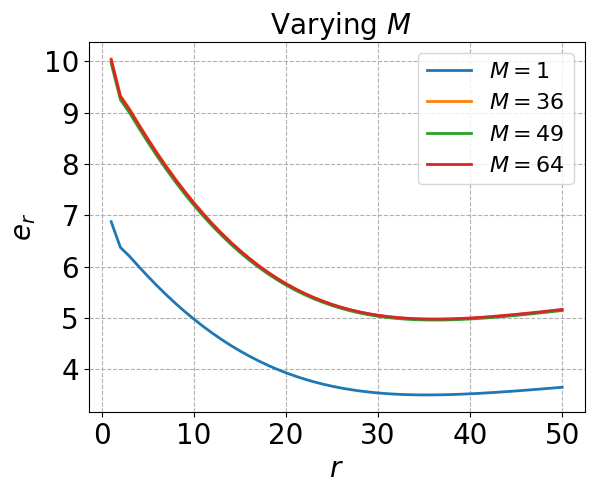

In [7]:
global_error=[]
M=[1,36,49,64]
N=10
eps=2
k=5
lr=0.1
error_sequence=[]
error_cal=1
R=50
client_error=[]
q=5
for m in M:
    seed_error=[]
    for q_idx in range(q):
        # theta_s,error=sys_id(m,10,0.01,R,K,SGD)
        error,global_ground_truth,final_params=fed_sys(m,N,eps,k,lr,error_cal,R)
        seed_error.append(error)
    avg_error=np.mean(seed_error,axis=0)
    plt.plot(range(1, R+1),avg_error,label=f'$M=${m}',linewidth=2)
    # error_sequence.append(error[-1])
plt.xlabel(r'$r$',fontsize=20)
plt.ylabel(r'$e_r$',fontsize=20)
plt.yticks(fontsize=20) 
plt.xticks(fontsize=20)  # Increase x-axis tick font size
plt.grid(True, which='both', linestyle='--')
# sorted_pairs = sorted(zip(error_sequence, M), reverse=True)
# sorted_error, sorted_M = zip(*sorted_pairs)
# sorted_error = list(sorted_error)
# sorted_M = list(sorted_M)
# plt.title(f'{N}_{eps}_{k}_{lr}_{error_cal}_varying_M_m_mod_Ax_Ay_Az_norm{sorted_M}')
plt.title(' Varying $M$',fontsize=20)
plt.legend(fontsize=16)
# plt.savefig('quad_sys_id_GD_M.png',bbox_inches='tight')
# plt.savefig(f'{N}_{eps}_{k}_{lr}_{error_cal}_varying_M_Ax_m_mod_Ax_Ay_Az_norm.png')

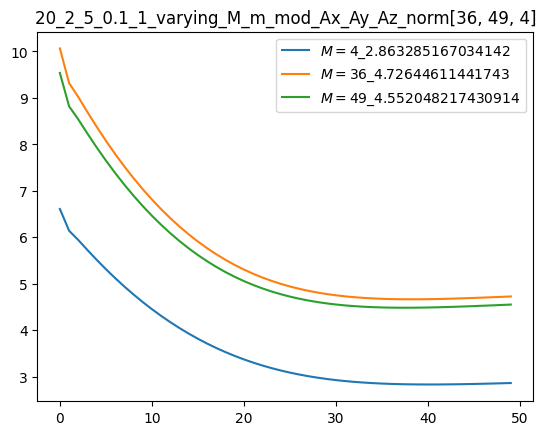

In [ ]:
global_error=[]
M=[4,36,49]
N=20
eps=2
k=5
lr=0.1
error_sequence=[]
error_cal=1
R=50
for m in M:
    error,global_ground_truth,final_params=fed_sys(m,N,eps,k,lr,error_cal,R)
    plt.plot(error,label=f'$M=${m}_{error[-1]}')
    error_sequence.append(error[-1])
sorted_pairs = sorted(zip(error_sequence, M), reverse=True)
sorted_error, sorted_M = zip(*sorted_pairs)
sorted_error = list(sorted_error)
sorted_M = list(sorted_M)
plt.title(f'{N}_{eps}_{k}_{lr}_{error_cal}_varying_M_m_mod_Ax_Ay_Az_norm{sorted_M}')
plt.legend(fontsize=16)
# plt.savefig(f'{N}_{eps}_{k}_{lr}_{error_cal}_varying_M_Ax_m_mod_Ax_Ay_Az_norm.png')

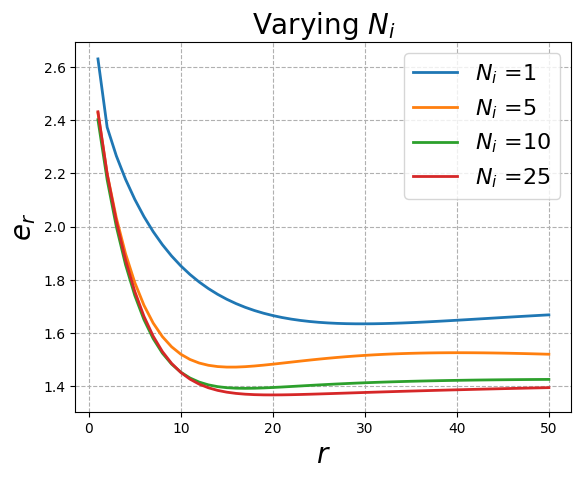

In [68]:
global_error=[]
M=5
N=[1,5,10,25]
eps=10
k=5
lr=0.1
# for n in N:
#     error,global_ground_truth,final_params=fed_sys(M,n,eps,k,lr,error_cal)
#     plt.plot(error,label=f'$N_i=${n}')
# plt.legend()
q=5
for index,n in enumerate(N):
    seed_error=[]
    for q_idx in range(q):
        error,global_ground_truth,final_params=fed_sys(M,n,eps,k,lr,error_cal)
        seed_error.append(error)
    avg_error=np.mean(seed_error,axis=0)
    plt.plot(range(1, R+1), avg_error,label=f'$N_i$ ={N[index]}',linewidth=2)
    plt.xlabel(r'$r$',fontsize=20)
    plt.ylabel(r'$e_r$',fontsize=20)
    # plt.xticks(fontsize=20)  # Increase x-axis tick font size
    # plt.yticks(fontsize=20)
    # plt.yticks(np.linspace(0.2, 1.00, 5)) 
    plt.title(r'Varying $N_i$',fontsize=20)
    plt.grid(True, which='both', linestyle='--')
    plt.legend(fontsize=16)
plt.savefig('quad_sys_id_GD_N.png',bbox_inches='tight')
# plt.savefig('Pendulum_sys_id_SGD_1_N.png',bbox_inches='tight')

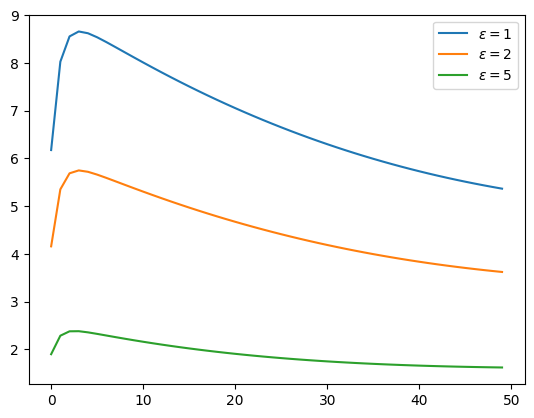

In [41]:
global_error=[]
M=5
# N=[5,10,25]
N=5
epsilon=[1,2,5]
        #  0.1,0.2,1,2,5,10]
# eps=0.75
k=2
lr=0.1
error_cal=0
for eps in epsilon:
    error,global_ground_truth,final_params=fed_sys(M,N,eps,k,lr,error_cal)
    plt.plot(error,label=f'$\\epsilon=${eps}')
plt.legend()